# Capstone Project - The Battle of the Neighbourhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction:Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

### Description of the problem and discussion of the background. 

#### Problem Background: 
London, one of the top tourism destinations in the world and home of many famous tourist attractions. London welcomed 20.42 million international tourists in 2018, a number that increases every year. London is also one of the biggest cities in the world with a total area of 1,572 km2 (607 sqm). As a tourist, we usually travel for 4-5 days and we have the tendency of trying to see everything during that time. But in a city that bog with so many famous attractions how can someone plan their days?

#### Problem Description:
In this project I tried to identify the most important attractions in London and group them into 5 groups based on their distance. Attractions that might have been further away from the city center have not been taken into account because as mentioned before this project is referred to tourists that do not have many days in London and want to visit as many places as they can. Briefly my project will answer the questions below:<br/>
•	Which attractions should I visit when in London? <br/>
•	How should I plan my days (which attractions to see) according to the distance of the places? <br/>
•	What kind of venues are nearby so I can visit? (for example, restaurants, hotels, spas etc)

#### Target Audience:
My project would be most successfully used by people who visit London for the first time and do not know of the attractions or the neighbourhoods of London. Also, it targets visitor that visit London for a short amount of time and want to visit mostly the city centre.


## Data <a name="data"></a>

One city will be analysed in this project: London\
\
I used the data from https://www.alva.org.uk/details.cfm?p=423 to create an excel file that includes all the major attractions in London, the category of the attraction (for example, museum, park), the number of visitors in 2018 and if it has free admission or the visitor need to pay a ticket.

These data were modified (more information in the methodology section) to fit the needs of the project. I added coordinates and erased attractions that might have been away from the city centre. 
I also used data from Foursquare that I used to find venues near each attraction


## Methodology <a name="methodology"></a>

First of all , we are going to start by importing the libraries we are going to need:

In [5]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

import matplotlib.pyplot as plt # library for visualisation
!conda install seaborn # library for visualisation

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

!pip install geopandas
!pip install geopy

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

import matplotlib.cm as cm
import matplotlib.colors as colors

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-

We are importing the xlsx file from my computer. The data were found at: https://www.alva.org.uk/details.cfm?p=423

In [6]:
from geopy.extra.rate_limiter import RateLimiter

In [7]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_f53bbadd1e864082adc59a06349b205d = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='wVVTRMNv8Z-Kk49QS0e5-FuSP9mzJr9s74Qnot8Xh0MW',
    ibm_auth_endpoint="https://iam.eu-gb.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_f53bbadd1e864082adc59a06349b205d.get_object(Bucket='capstone-donotdelete-pr-5i4z7tkstjwdd1',Key='most_visited_london.xlsx')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_excel(body)
df.head()


,Name of Attraction,Category,2018 Visitors,Type
0,Tower of London,Historic Properties,2855438,Paid
1,"Royal Botanic Gardens, Kew*",Gardens,1858513,Paid
2,St Paul's Cathedral,Places of Worship,1657446,Paid
3,Royal Academy of Arts,Museums & Art Galleries,1594140,Paid
4,Westminster Abbey,Places of Worship,1546017,Paid


We are going to sort our dataframe according to the name of attraction in alphabetical order.

In [8]:
df.sort_values(by=['Name of Attraction'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Name of Attraction,Category,2018 Visitors,Type
0,British Library,Museums & Art Galleries,1437839,Free
1,British Museum,Museums & Art\nGalleries,5828552,Free
2,Chelsea Physic Garden,Gardens,66914,Paid
3,Churchill War Rooms,Visitor Centre,579612,Paid
4,Down House - Home of Charles Darwin,Historic Properties,50232,Paid


We will be adding coordinates for each attraction in our dataframe

In [9]:
# 1 - conveneint function to delay between geocoding calls
locator = Nominatim(user_agent='myGeocoder')
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
df['location'] = df['Name of Attraction'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
df['point'] = df['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
df[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df['point'].tolist(), index=df.index)
df.drop(['location','point','altitude'], axis=1, inplace=True)
df.head()

,Name of Attraction,Category,2018 Visitors,Type,latitude,longitude
0,British Library,Museums & Art Galleries,1437839,Free,51.529877,-0.127720
1,British Museum,Museums & Art\nGalleries,5828552,Free,51.519294,-0.128018
2,Chelsea Physic Garden,Gardens,66914,Paid,51.484585,-0.162179
3,Churchill War Rooms,Visitor Centre,579612,Paid,51.502202,-0.129349
4,Down House - Home of Charles Darwin,Historic Properties,50232,Paid,51.331449,0.053387


Let's use Folium to show these attractions on a map.

In [10]:
address = 'London, UK'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, attraction in zip(df['latitude'], df['longitude'], df['Name of Attraction']):
    label = '{}'.format(attraction)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

The geograpical coordinate of London are 51.5073219, -0.1276474.


We see that there some points that can be considered as outliers. Since a person is probaby going to be visiting the centre of London we are going to remove some attraction that are more far away.

In [11]:
outliers=["Hampton Court Palace","Down House - Home of Charles Darwin","Osterley Park and House","Royal Air Force Museum London",
          "Royal Botanic Gardens, Kew*","Kenwood House","Eltham Palace","Horniman Museum and Gardens","London Wetland Centre"]
df_no_outliers = df[~df['Name of Attraction'].isin(outliers)]
df_no_outliers.reset_index(drop=True, inplace=True)
df_no_outliers.head()

,Name of Attraction,Category,2018 Visitors,Type,latitude,longitude
0,British Library,Museums & Art Galleries,1437839,Free,51.529877,-0.127720
1,British Museum,Museums & Art\nGalleries,5828552,Free,51.519294,-0.128018
2,Chelsea Physic Garden,Gardens,66914,Paid,51.484585,-0.162179
3,Churchill War Rooms,Visitor Centre,579612,Paid,51.502202,-0.129349
4,Guildhall Art Gallery,Museums & Art Galleries,116616,Free,51.515511,-0.091407


Let's see the map now without the attraction that are far away from the city centre.

In [12]:
address = 'London, UK'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of London using latitude and longitude values
map_london_no_outliers = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, attraction in zip(df_no_outliers['latitude'], df_no_outliers['longitude'], df_no_outliers['Name of Attraction']):
    label = '{}'.format(attraction)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london_no_outliers)  
    
map_london_no_outliers

Now let's combine these with data from Foursquare

In [13]:
CLIENT_ID = '3RPQWX4H2VOKFOKOSERPS0BQGBULI00EELUXSFQEFXVFKJZG' # your Foursquare ID
CLIENT_SECRET = '1IMJFLUAUQA5ZLDGRFWZLDPFHR2TXR1ELVQ0UEW155VXXF41' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

Function to getting venues that are nearby the attraction using the Foursquare API

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name of Attraction', 
                  "Attraction's Latitude", 
                  "Attraction's Longitude", 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
london_venues = getNearbyVenues(names=df_no_outliers['Name of Attraction'],
                                   latitudes=df_no_outliers['latitude'],
                                   longitudes=df_no_outliers['longitude'])

British Library
British Museum
Chelsea Physic Garden
Churchill War Rooms
Guildhall Art Gallery
HMS Belfast
Household Cavalry Museum
Houses of Parliament
Imperial War Museum London
Kensington Palace
London Transport Museum
Museum of London
Museum of London Docklands
National Gallery
National Portrait Gallery
Natural History Museum London
Royal Academy of Arts
Science Museum
Serpentine Gallery
Shakespeare's Globe
Sir John Soane's Museum
Somerset House
St Paul's Cathedral
Tate Britain
Tate Modern
Tower Bridge Exhibition
Tower of London
V&A (South Kensington)
V&A Museum of Childhood
Westminster Abbey
ZSL London Zoo


In [16]:
print(london_venues.shape)
london_venues.head()

(2382, 7)


,Name of Attraction,Attraction's Latitude,Attraction's Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,British Library,51.529877,-0.12772,The Sir John Ritblat Gallery: Treasures of the...,51.529666,-0.127541,Museum
1,British Library,51.529877,-0.12772,M&S Simply Food,51.530964,-0.125591,Grocery Store
2,British Library,51.529877,-0.12772,London St Pancras International Railway Statio...,51.531371,-0.126022,Train Station
3,British Library,51.529877,-0.12772,Pullman London St Pancras,51.528521,-0.128161,Hotel
4,British Library,51.529877,-0.12772,St. Pancras Renaissance Hotel London,51.529699,-0.125887,Hotel


In [17]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 233 uniques categories.


As we can see even from the top 5 rows there might some attractions included. So to avoid duplicates or attractions that are not actually visited often we are going to be droping the rows that include these kind of data.

In [18]:
#List unique values in the Venue Category column
london_venues['Venue Category'].unique()

array(['Museum', 'Grocery Store', 'Train Station', 'Hotel',
       'Breakfast Spot', 'Coffee Shop', 'Chocolate Shop', 'Dessert Shop',
       'Gift Shop', 'English Restaurant', 'Hotel Bar', 'Sushi Restaurant',
       'Sandwich Place', 'Juice Bar', 'Restaurant', 'Café',
       'Malay Restaurant', 'Modern European Restaurant',
       'Gym / Fitness Center', 'Dance Studio', 'Deli / Bodega',
       'Turkish Restaurant', 'Gastropub', 'Film Studio',
       'Stationery Store', 'Pharmacy', 'Garden', 'Souvenir Shop', 'Plaza',
       'Fish & Chips Shop', 'Pizza Place', 'Market', 'Italian Restaurant',
       'Beer Bar', 'Portuguese Restaurant', 'Tapas Restaurant',
       'Art Gallery', 'Pub', 'Sporting Goods Shop', 'Bookstore',
       "Women's Store", 'Pool Hall', 'Chinese Restaurant',
       'Szechuan Restaurant', 'Bar', 'Pastry Shop', 'Dog Run',
       'Burger Joint', 'Australian Restaurant', 'Fast Food Restaurant',
       'History Museum', 'Exhibit', 'Liquor Store', 'Greek Restaurant',
       '

In [19]:
venues_included=["Art Gallery","Art Museum","Botanical Garden","Castle","Garden","Garden Center","Historic Site","History Museum",
                "Monument / Landmark","Museum","Park","Palace"]
london_venues = london_venues[~london_venues['Venue Category'].isin(venues_included)]
london_venues.reset_index(drop=True, inplace=True)
london_venues.head()

,Name of Attraction,Attraction's Latitude,Attraction's Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,British Library,51.529877,-0.12772,M&S Simply Food,51.530964,-0.125591,Grocery Store
1,British Library,51.529877,-0.12772,London St Pancras International Railway Statio...,51.531371,-0.126022,Train Station
2,British Library,51.529877,-0.12772,Pullman London St Pancras,51.528521,-0.128161,Hotel
3,British Library,51.529877,-0.12772,St. Pancras Renaissance Hotel London,51.529699,-0.125887,Hotel
4,British Library,51.529877,-0.12772,Pullman Hotel Breakfast Area,51.528484,-0.128126,Breakfast Spot


In [20]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 222 uniques categories.


Let's create a bar chart to visualise the number of venues near each of the attractions

[Text(0, 0, 'British Library'),
 Text(0, 0, 'British Museum'),
 Text(0, 0, 'Chelsea Physic Garden'),
 Text(0, 0, 'Churchill War Rooms'),
 Text(0, 0, 'Guildhall Art Gallery'),
 Text(0, 0, 'HMS Belfast'),
 Text(0, 0, 'Household Cavalry Museum'),
 Text(0, 0, 'Houses of Parliament'),
 Text(0, 0, 'Imperial War Museum London'),
 Text(0, 0, 'Kensington Palace'),
 Text(0, 0, 'London Transport Museum'),
 Text(0, 0, 'Museum of London'),
 Text(0, 0, 'Museum of London Docklands'),
 Text(0, 0, 'National Gallery'),
 Text(0, 0, 'National Portrait Gallery'),
 Text(0, 0, 'Natural History Museum London'),
 Text(0, 0, 'Royal Academy of Arts'),
 Text(0, 0, 'Science Museum'),
 Text(0, 0, 'Serpentine Gallery'),
 Text(0, 0, "Shakespeare's Globe"),
 Text(0, 0, "Sir John Soane's Museum"),
 Text(0, 0, 'Somerset House'),
 Text(0, 0, "St Paul's Cathedral"),
 Text(0, 0, 'Tate Britain'),
 Text(0, 0, 'Tate Modern'),
 Text(0, 0, 'Tower Bridge Exhibition'),
 Text(0, 0, 'Tower of London'),
 Text(0, 0, 'V&A (South Kensi

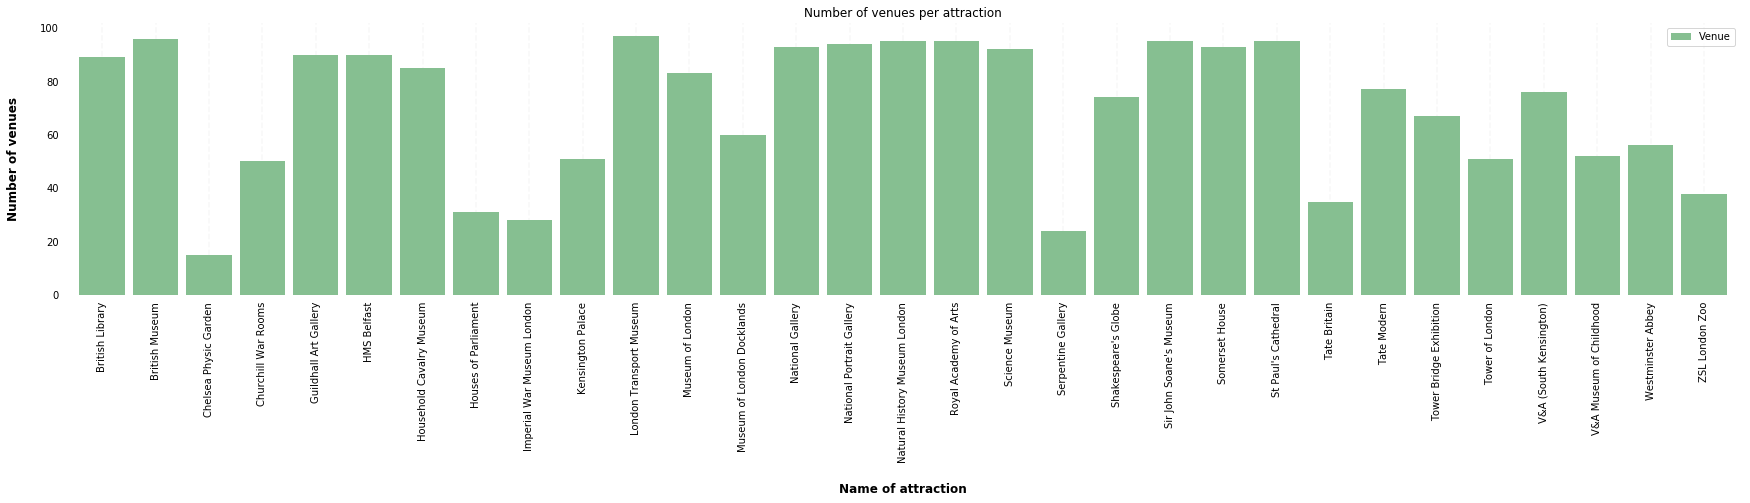

In [21]:
london_venues_count=london_venues.groupby('Name of Attraction').count()
london_venues_count.drop(["Attraction's Latitude","Attraction's Longitude",'Venue Latitude','Venue Longitude','Venue Category'], axis=1, inplace=True)
london_venues_count.reset_index(inplace=True) 

ax = london_venues_count.plot(kind='bar', figsize=(30, 5), color='#86bf91', zorder=2, width=0.85)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Switch off ticks
ax.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, left=False, right=False, labelleft=True)

# Draw vertical axis lines
vals = ax.get_xticks()
for tick in vals:
    ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set x-axis label
ax.set_xlabel("Name of attraction", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Number of venues", labelpad=20, weight='bold', size=12)

ax.set_title('Number of venues per attraction')
ax.set_xticklabels(london_venues_count['Name of Attraction'])

In [22]:
# one hot encoding
london_categories = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_categories['Name of Attraction'] = london_venues['Name of Attraction'] 

# move neighborhood column to the first column
fixed_columns = [london_categories.columns[-1]] + list(london_categories.columns[:-1])
london_categories = london_categories[fixed_columns]

london_categories.head()

,Name of Attraction,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Watch Shop,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,British Library,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,British Library,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,British Library,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,British Library,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,British Library,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
london_categories_grouped = london_categories.groupby('Name of Attraction').mean().reset_index()
london_categories_grouped.head()

,Name of Attraction,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Watch Shop,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,British Library,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.011236,0.000000,0.000000,0.0
1,British Museum,0.010417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.010417,0.0,0.010417,0.000000,0.000000,0.000000,0.0
2,Chelsea Physic Garden,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.066667,0.000000,0.066667,0.0
3,Churchill War Rooms,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,Guildhall Art Gallery,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.033333,0.0,0.022222,0.0,0.000000,0.000000,0.022222,0.000000,0.0


In [24]:
num_top_venues = 5

for hood in london_categories_grouped['Name of Attraction']:
    print("----"+hood+"----")
    temp = london_categories_grouped[london_categories_grouped['Name of Attraction'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----British Library----
                venue  freq
0                 Pub  0.09
1         Coffee Shop  0.09
2                Café  0.08
3               Hotel  0.07
4  Italian Restaurant  0.03


----British Museum----
          venue  freq
0   Coffee Shop  0.09
1       Exhibit  0.07
2         Hotel  0.05
3     Bookstore  0.04
4  Cocktail Bar  0.03


----Chelsea Physic Garden----
                venue  freq
0                 Pub  0.20
1       Grocery Store  0.13
2  Italian Restaurant  0.07
3     Harbor / Marina  0.07
4         Pizza Place  0.07


----Churchill War Rooms----
               venue  freq
0                Pub  0.18
1               Café  0.12
2  Outdoor Sculpture  0.10
3        Coffee Shop  0.10
4              Plaza  0.08


----Guildhall Art Gallery----
                  venue  freq
0           Coffee Shop  0.11
1    Italian Restaurant  0.06
2                  Café  0.04
3  Gym / Fitness Center  0.03
4            Restaurant  0.03


----HMS Belfast----
          venue  freq
0  

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Name of Attraction']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
london_categories_sorted = pd.DataFrame(columns=columns)
london_categories_sorted ['Name of Attraction'] = london_categories_grouped['Name of Attraction']

for ind in np.arange(london_categories_grouped.shape[0]):
    london_categories_sorted.iloc[ind, 1:] = return_most_common_venues(london_categories_grouped.iloc[ind, :], num_top_venues)

london_categories_sorted

,Name of Attraction,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,British Library,Pub,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Sushi Restaurant,Train Station,Hotel Bar,Sandwich Place
1,British Museum,Coffee Shop,Exhibit,Hotel,Bookstore,Cocktail Bar,Bar,Japanese Restaurant,Korean Restaurant,Greek Restaurant,Gift Shop
2,Chelsea Physic Garden,Pub,Grocery Store,Pizza Place,Gym / Fitness Center,Steakhouse,French Restaurant,Italian Restaurant,Bar,Burger Joint,Harbor / Marina
3,Churchill War Rooms,Pub,Café,Coffee Shop,Outdoor Sculpture,Plaza,Hotel,Sandwich Place,Bookstore,Gift Shop,Indie Movie Theater
4,Guildhall Art Gallery,Coffee Shop,Italian Restaurant,Café,Seafood Restaurant,Gym / Fitness Center,Sushi Restaurant,Restaurant,Hotel,French Restaurant,Steakhouse
5,HMS Belfast,Coffee Shop,Hotel,Bar,Restaurant,Cocktail Bar,Pub,English Restaurant,French Restaurant,Scenic Lookout,Gym / Fitness Center
6,Household Cavalry Museum,Pub,Outdoor Sculpture,Hotel,Plaza,Coffee Shop,Café,Theater,French Restaurant,Sandwich Place,Bookstore
7,Houses of Parliament,Pub,Plaza,Café,Outdoor Sculpture,Sandwich Place,Coffee Shop,Hotel,Indian Restaurant,Bar,Concert Hall
8,Imperial War Museum London,Pub,Coffee Shop,Sandwich Place,Plaza,Hotel,Café,Bar,Dance Studio,Food & Drink Shop,Gastropub
9,Kensington Palace,Hotel,Clothing Store,Restaurant,Café,Juice Bar,French Restaurant,Grocery Store,Pub,Spa,Chinese Restaurant


We are going to use k-means clustering according to location to group nearby attractions.

In [27]:
# set number of clusters
kclusters = 5

london_grouped_clustering = df_no_outliers.drop(['Name of Attraction', 'Type','Category','2018 Visitors'] , 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50] 

array([2, 2, 1, 4, 3, 3, 4, 4, 4, 1, 4, 3, 0, 4, 4, 1, 4, 1, 1, 3, 4, 4,
       3, 4, 3, 3, 3, 1, 0, 4, 2], dtype=int32)

In [28]:
london_categories_sorted=london_categories_sorted.sort_values(by=['Name of Attraction'])
london_categories_sorted

,Name of Attraction,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,British Library,Pub,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Sushi Restaurant,Train Station,Hotel Bar,Sandwich Place
1,British Museum,Coffee Shop,Exhibit,Hotel,Bookstore,Cocktail Bar,Bar,Japanese Restaurant,Korean Restaurant,Greek Restaurant,Gift Shop
2,Chelsea Physic Garden,Pub,Grocery Store,Pizza Place,Gym / Fitness Center,Steakhouse,French Restaurant,Italian Restaurant,Bar,Burger Joint,Harbor / Marina
3,Churchill War Rooms,Pub,Café,Coffee Shop,Outdoor Sculpture,Plaza,Hotel,Sandwich Place,Bookstore,Gift Shop,Indie Movie Theater
4,Guildhall Art Gallery,Coffee Shop,Italian Restaurant,Café,Seafood Restaurant,Gym / Fitness Center,Sushi Restaurant,Restaurant,Hotel,French Restaurant,Steakhouse
5,HMS Belfast,Coffee Shop,Hotel,Bar,Restaurant,Cocktail Bar,Pub,English Restaurant,French Restaurant,Scenic Lookout,Gym / Fitness Center
6,Household Cavalry Museum,Pub,Outdoor Sculpture,Hotel,Plaza,Coffee Shop,Café,Theater,French Restaurant,Sandwich Place,Bookstore
7,Houses of Parliament,Pub,Plaza,Café,Outdoor Sculpture,Sandwich Place,Coffee Shop,Hotel,Indian Restaurant,Bar,Concert Hall
8,Imperial War Museum London,Pub,Coffee Shop,Sandwich Place,Plaza,Hotel,Café,Bar,Dance Studio,Food & Drink Shop,Gastropub
9,Kensington Palace,Hotel,Clothing Store,Restaurant,Café,Juice Bar,French Restaurant,Grocery Store,Pub,Spa,Chinese Restaurant


In [29]:
# add clustering labels

london_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
london_categories_sorted

,Cluster Labels,Name of Attraction,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,British Library,Pub,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Sushi Restaurant,Train Station,Hotel Bar,Sandwich Place
1,2,British Museum,Coffee Shop,Exhibit,Hotel,Bookstore,Cocktail Bar,Bar,Japanese Restaurant,Korean Restaurant,Greek Restaurant,Gift Shop
2,1,Chelsea Physic Garden,Pub,Grocery Store,Pizza Place,Gym / Fitness Center,Steakhouse,French Restaurant,Italian Restaurant,Bar,Burger Joint,Harbor / Marina
3,4,Churchill War Rooms,Pub,Café,Coffee Shop,Outdoor Sculpture,Plaza,Hotel,Sandwich Place,Bookstore,Gift Shop,Indie Movie Theater
4,3,Guildhall Art Gallery,Coffee Shop,Italian Restaurant,Café,Seafood Restaurant,Gym / Fitness Center,Sushi Restaurant,Restaurant,Hotel,French Restaurant,Steakhouse
5,3,HMS Belfast,Coffee Shop,Hotel,Bar,Restaurant,Cocktail Bar,Pub,English Restaurant,French Restaurant,Scenic Lookout,Gym / Fitness Center
6,4,Household Cavalry Museum,Pub,Outdoor Sculpture,Hotel,Plaza,Coffee Shop,Café,Theater,French Restaurant,Sandwich Place,Bookstore
7,4,Houses of Parliament,Pub,Plaza,Café,Outdoor Sculpture,Sandwich Place,Coffee Shop,Hotel,Indian Restaurant,Bar,Concert Hall
8,4,Imperial War Museum London,Pub,Coffee Shop,Sandwich Place,Plaza,Hotel,Café,Bar,Dance Studio,Food & Drink Shop,Gastropub
9,1,Kensington Palace,Hotel,Clothing Store,Restaurant,Café,Juice Bar,French Restaurant,Grocery Store,Pub,Spa,Chinese Restaurant


In [30]:
london_merged = df_no_outliers

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(london_categories_sorted.set_index('Name of Attraction'), on='Name of Attraction')

london_merged # check the last columns!

,Name of Attraction,Category,2018 Visitors,Type,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,British Library,Museums & Art Galleries,1437839,Free,51.529877,-0.127720,2,Pub,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Sushi Restaurant,Train Station,Hotel Bar,Sandwich Place
1,British Museum,Museums & Art\nGalleries,5828552,Free,51.519294,-0.128018,2,Coffee Shop,Exhibit,Hotel,Bookstore,Cocktail Bar,Bar,Japanese Restaurant,Korean Restaurant,Greek Restaurant,Gift Shop
2,Chelsea Physic Garden,Gardens,66914,Paid,51.484585,-0.162179,1,Pub,Grocery Store,Pizza Place,Gym / Fitness Center,Steakhouse,French Restaurant,Italian Restaurant,Bar,Burger Joint,Harbor / Marina
3,Churchill War Rooms,Visitor Centre,579612,Paid,51.502202,-0.129349,4,Pub,Café,Coffee Shop,Outdoor Sculpture,Plaza,Hotel,Sandwich Place,Bookstore,Gift Shop,Indie Movie Theater
4,Guildhall Art Gallery,Museums & Art Galleries,116616,Free,51.515511,-0.091407,3,Coffee Shop,Italian Restaurant,Café,Seafood Restaurant,Gym / Fitness Center,Sushi Restaurant,Restaurant,Hotel,French Restaurant,Steakhouse
5,HMS Belfast,Historic Properties,297941,Paid,51.506520,-0.081120,3,Coffee Shop,Hotel,Bar,Restaurant,Cocktail Bar,Pub,English Restaurant,French Restaurant,Scenic Lookout,Gym / Fitness Center
6,Household Cavalry Museum,Museums & Art Galleries,54155,Paid,51.504949,-0.127156,4,Pub,Outdoor Sculpture,Hotel,Plaza,Coffee Shop,Café,Theater,French Restaurant,Sandwich Place,Bookstore
7,Houses of Parliament,Historic Properties,1075550,Paid,51.499425,-0.124448,4,Pub,Plaza,Café,Outdoor Sculpture,Sandwich Place,Coffee Shop,Hotel,Indian Restaurant,Bar,Concert Hall
8,Imperial War Museum London,Museums & Art\nGalleries,1061798,Free,51.495617,-0.108598,4,Pub,Coffee Shop,Sandwich Place,Plaza,Hotel,Café,Bar,Dance Studio,Food & Drink Shop,Gastropub
9,Kensington Palace,Historic Properties,550185,Paid,51.505099,-0.187633,1,Hotel,Clothing Store,Restaurant,Café,Juice Bar,French Restaurant,Grocery Store,Pub,Spa,Chinese Restaurant


Let's create a map to see our custers

In [31]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['latitude'], london_merged['longitude'], london_merged['Name of Attraction'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now we are going to see each cluster seperately:

In [32]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0,1,2,3] + list(range(6, london_merged.shape[1]))]]

,Name of Attraction,Category,2018 Visitors,Type,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Museum of London Docklands,Museums & Art\nGalleries,290488,Free,0,Coffee Shop,Italian Restaurant,Plaza,Burger Joint,Gym / Fitness Center,Indian Restaurant,Sandwich Place,Restaurant,Pizza Place,Hotel
28,V&A Museum of Childhood,Museums & Art\nGalleries,418271,Free,0,Coffee Shop,Pub,Café,Cocktail Bar,Beer Bar,Hotel,Pizza Place,Fast Food Restaurant,Grocery Store,Church


In [33]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0,1,2,3] + list(range(6, london_merged.shape[1]))]]

,Name of Attraction,Category,2018 Visitors,Type,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Chelsea Physic Garden,Gardens,66914,Paid,1,Pub,Grocery Store,Pizza Place,Gym / Fitness Center,Steakhouse,French Restaurant,Italian Restaurant,Bar,Burger Joint,Harbor / Marina
9,Kensington Palace,Historic Properties,550185,Paid,1,Hotel,Clothing Store,Restaurant,Café,Juice Bar,French Restaurant,Grocery Store,Pub,Spa,Chinese Restaurant
15,Natural History Museum London,Museums & Art\nGalleries,5226320,Free,1,Hotel,Exhibit,Science Museum,Café,Bakery,Ice Cream Shop,Italian Restaurant,Pizza Place,Sandwich Place,Burger Joint
17,Science Museum,Museums & Art\nGalleries,3174963,Free,1,Hotel,Café,Exhibit,Science Museum,Ice Cream Shop,Bakery,Gift Shop,Burger Joint,Italian Restaurant,Sandwich Place
18,Serpentine Gallery,Museums & Art\nGalleries,1208531,Free,1,Outdoor Sculpture,Café,Fountain,Lake,Champagne Bar,Tennis Court,Bus Stop,Bar,Restaurant,Scenic Lookout
27,V&A (South Kensington),Museums & Art\nGalleries,3967566,Free,1,Italian Restaurant,Bakery,Juice Bar,Sandwich Place,Steakhouse,Coffee Shop,Pizza Place,Café,Japanese Restaurant,Grocery Store


In [34]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0,1,2,3] + list(range(6, london_merged.shape[1]))]]

,Name of Attraction,Category,2018 Visitors,Type,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,British Library,Museums & Art Galleries,1437839,Free,2,Pub,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Sushi Restaurant,Train Station,Hotel Bar,Sandwich Place
1,British Museum,Museums & Art\nGalleries,5828552,Free,2,Coffee Shop,Exhibit,Hotel,Bookstore,Cocktail Bar,Bar,Japanese Restaurant,Korean Restaurant,Greek Restaurant,Gift Shop
30,ZSL London Zoo,Wildlife,1133952,Paid,2,Zoo Exhibit,Café,Playground,Athletics & Sports,Harbor / Marina,Food & Drink Shop,Chinese Restaurant,Diner,Fountain,Gift Shop


In [35]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0,1,2,3] + list(range(6, london_merged.shape[1]))]]

,Name of Attraction,Category,2018 Visitors,Type,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Guildhall Art Gallery,Museums & Art Galleries,116616,Free,3,Coffee Shop,Italian Restaurant,Café,Seafood Restaurant,Gym / Fitness Center,Sushi Restaurant,Restaurant,Hotel,French Restaurant,Steakhouse
5,HMS Belfast,Historic Properties,297941,Paid,3,Coffee Shop,Hotel,Bar,Restaurant,Cocktail Bar,Pub,English Restaurant,French Restaurant,Scenic Lookout,Gym / Fitness Center
11,Museum of London,Museums & Art\nGalleries,694596,Free,3,Coffee Shop,Italian Restaurant,Sandwich Place,Plaza,Sushi Restaurant,Gym / Fitness Center,French Restaurant,Hotel,Modern European Restaurant,Clothing Store
19,Shakespeare's Globe,Visitor Centre,819000,Paid,3,Coffee Shop,Gym / Fitness Center,Italian Restaurant,Pub,Hotel,Café,Asian Restaurant,Portuguese Restaurant,Spanish Restaurant,Bakery
22,St Paul's Cathedral,Places of Worship,1657446,Paid,3,Coffee Shop,Italian Restaurant,Pub,Sandwich Place,Plaza,Gym / Fitness Center,Wine Bar,Restaurant,Vietnamese Restaurant,Bakery
24,Tate Modern,Museums & Art\nGalleries,5868562,Free,3,Hotel,Gym / Fitness Center,Pub,Italian Restaurant,Coffee Shop,Performing Arts Venue,Wine Bar,Cocktail Bar,Pedestrian Plaza,Portuguese Restaurant
25,Tower Bridge Exhibition,Historic Properties,836654,Paid,3,Pub,Hotel,Coffee Shop,Italian Restaurant,Bar,English Restaurant,Scenic Lookout,Cocktail Bar,Theater,Hotel Bar
26,Tower of London,Historic Properties,2855438,Paid,3,Hotel,Gym / Fitness Center,Scenic Lookout,Coffee Shop,Tapas Restaurant,Cocktail Bar,French Restaurant,Hotel Bar,Modern European Restaurant,Beer Bar


In [36]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0,1,2,3] + list(range(6, london_merged.shape[1]))]]

,Name of Attraction,Category,2018 Visitors,Type,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Churchill War Rooms,Visitor Centre,579612,Paid,4,Pub,Café,Coffee Shop,Outdoor Sculpture,Plaza,Hotel,Sandwich Place,Bookstore,Gift Shop,Indie Movie Theater
6,Household Cavalry Museum,Museums & Art Galleries,54155,Paid,4,Pub,Outdoor Sculpture,Hotel,Plaza,Coffee Shop,Café,Theater,French Restaurant,Sandwich Place,Bookstore
7,Houses of Parliament,Historic Properties,1075550,Paid,4,Pub,Plaza,Café,Outdoor Sculpture,Sandwich Place,Coffee Shop,Hotel,Indian Restaurant,Bar,Concert Hall
8,Imperial War Museum London,Museums & Art\nGalleries,1061798,Free,4,Pub,Coffee Shop,Sandwich Place,Plaza,Hotel,Café,Bar,Dance Studio,Food & Drink Shop,Gastropub
10,London Transport Museum,Museums & Art Galleries,353921,Paid,4,Theater,Coffee Shop,Burger Joint,Clothing Store,Hotel,Cocktail Bar,Ice Cream Shop,Restaurant,Bakery,Dessert Shop
13,National Gallery,Museums & Art\nGalleries,5735831,Free,4,Theater,Hotel,Bakery,Ice Cream Shop,Pub,Wine Bar,Burger Joint,Italian Restaurant,Speakeasy,Japanese Restaurant
14,National Portrait Gallery,Museums & Art\nGalleries,1586451,Free,4,Theater,Bakery,Pub,Hotel,Ice Cream Shop,Wine Bar,Pizza Place,French Restaurant,Italian Restaurant,Speakeasy
16,Royal Academy of Arts,Museums & Art Galleries,1594140,Paid,4,Boutique,Clothing Store,Cocktail Bar,Men's Store,Women's Store,Bookstore,Dessert Shop,Hotel,Jewelry Store,Restaurant
20,Sir John Soane's Museum,Museums & Art\nGalleries,133407,Free,4,Pub,Coffee Shop,Restaurant,Sandwich Place,Hotel,Theater,Korean Restaurant,Japanese Restaurant,Italian Restaurant,Sushi Restaurant
21,Somerset House,Historic Properties,3143626,Free,4,Theater,Coffee Shop,Burger Joint,French Restaurant,Hotel,Restaurant,Cocktail Bar,Dessert Shop,Tea Room,Ice Cream Shop


## Results <a name="results"></a>

As we can see in the map above, we have 5 different groups (purple, red, blue, light blue and yellow dots).\
\
Let’s examine each cluster separately:\
\
Cluster 0 or group 1 (red dots) has only 2 attractions, the two attractions that are east from Central London.\
Cluster 1 or group 2 (purple dots) has 6 attractions, the ones west from Central London.\
Cluster 2 or group 3 (blue dots) has 3 attractions, the ones a bit north from Central London.\
\
We can see that Central London has too many attractions so these were divided into two groups or clusters:\
\
Cluster 3 or group 4 (light blue dots) that has 8 attractions\
Cluster 4 or group 5 (yellow dots) that has 12 attractions.




## Discussion <a name="discussion"></a>

According to our analysis we can see that 5 days are quite enough to visit London – mostly Central London. If we need to check for less or more days we can just change the number of the clusters into 4 and 6 accordingly. We can see that the clusters are not equal, some clusters have 2 attractions and some clusters have 12. So that may cause a problem. However, it is obvious from Figure 16 that the cluster with the two attractions is the one that is the furthest away from the centre and also the two attractions are far away from each other, so it will take more time to commute.\
\
Our project also shows us that the most common venues near the centre are theatres, coffee shops and pubs, making it the perfect destination for an afternoon activity or outing. On the other hand we can see that in West London the most common venues are hotels, so maybe we could propose for the tourist to stay there.

#### Limitations:
\
This project lacks to plan days to visit attractions much further away from the centre. These attractions were removed as outliers. However, if we wanted to include them, maybe for visitors that will stay more days k-means would probably not work. In order to include them we could use DBSCAN, a data clustering algorithm that groups together points that are closely packed together, marking as outliers points that lie alone in low-density regions.

#### Further projects:
\
In a following project we can also use Foursquare to identify the top rated venues near the attractions and propose them to the visitor.



## Conclusion <a name="conclusion"></a>

This project is meant to be used by first-time tourists in London that are supposed to travel for few days. It illustrates in a map all the major attractions and the user can also use the data to identify how many visitors visited each attraction in 2018 and if the attraction is free or not. Also, it groups attractions that are near and thus proposing ways to organise 5 days. Which attractions to see in one day. Finally, it shows the most common venues near each attraction allowing the person using the program to identify what is nearby and plan their entertainment, staying or eating.